In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [3]:
df_test = pd.read_csv("./data_10k.csv", sep=',')

In [4]:
df_test.shape

(10000, 9663)

In [5]:
df = df_test.set_index("id")

In [6]:
a = pd.DataFrame(df.sum()).sort_values(by=0, ascending=False)
b = pd.DataFrame(df.sum(axis=1)).sort_values(by=0, ascending=False)

In [7]:
translation_recipe_id_index = df_test['id'].reset_index().set_index('id').to_dict()['index']

In [8]:
#a[a[0] > 1][:30]

In [9]:
df['pepper'] = df['pepper'] + df['ground pepper']
df['pepper'] = df['pepper'] + df['salt pepper']
df['salt'] = df['salt'] + df['salt pepper']
df['salt'] = df['salt'].clip(0,1)
df['pepper'] = df['pepper'].clip(0,1)

In [10]:
columns = a[a[0] > 1].index.values
drop_columns = ["salt ground pepper", "half", "salt pepper", "ground pepper"]
cols = np.setdiff1d(columns, drop_columns)

In [11]:
df_clean = df[cols]

In [12]:
Sortedingredients = pd.DataFrame(df_clean.sum()).sort_values(by=0, ascending=False)

In [13]:
df_clean.shape

(10000, 2754)

In [14]:
df_clean.head()

,2-percent yogurt,aburaage,accompaniment lemon wedge,adobo,adobo sauce,agave nectar,ahi tuna,ale,alfredo sauce,allspice,...,yukon gold potato,yukon gold potato chunk,yuzu juice,zest,zesty,ziti pasta,zucchini,zucchini chunk,zucchini piece,zucchini summer squash
id,,,,,,,,,,,,,,,,,,,,,
6a90237a1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f3234317a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fe207a8ce1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ebd602ad45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f38f4ee25d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df_clean.isnull().sum().sum()

0

In [16]:
features = df_clean.values
features.shape

(10000, 2754)

In [17]:
def compute_euclidean_distance(X):
    return  np.sqrt(-2 * np.dot(X, X.T) + np.sum(X**2, axis=1) + np.expand_dims(np.sum(X**2, axis=1), 1))

In [18]:
nbingredients=features.shape[1]
nbrecettes=features.shape[0]
distancerecipes = compute_euclidean_distance(features)
print(distancerecipes.shape)

distanceingredients=np.zeros((nbingredients, nbingredients))

for i in range(nbrecettes):
    a=features[i]!=0
    listindexingredients=[j for j, x in enumerate(a) if x]
    #print(listindexingredients)
    for pair in itertools.product(listindexingredients, repeat=2):
        #print(pair)
        distanceingredients[pair[0], pair[1]] = distanceingredients[pair[0], pair[1]]+1
for j in range(nbingredients):
    distanceingredients[j,j]=0

(10000, 10000)


In [19]:
meanconnectioningredients=distanceingredients.mean()
mean_distance_recipes = distancerecipes.mean()

****Properties of the ingredients****

In [42]:
Sortedingredients[Sortedingredients[0] > 1][:10]

,0
salt,4527.0
pepper,3176.0
sugar,3081.0
onion,2819.0
egg,2282.0
butter,2229.0
flour,1999.0
water,1753.0
milk,1456.0
olive oil,1456.0


In [26]:
print(distanceingredients.mean())

0.08306265027326727


This is not the mean distance but the mean number of recipes in common between two distinct ingredients.

2448.0


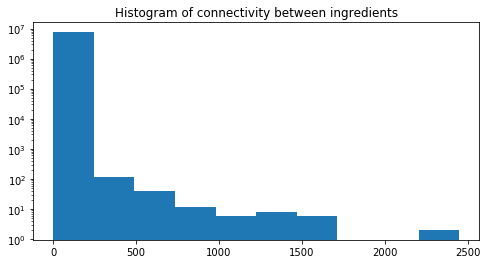

In [27]:
print(distanceingredients.max())
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of connectivity between ingredients")
plt.hist(distanceingredients.flatten(), log=True);


In [38]:
Threshold=20
print(sum(sum(distanceingredients>Threshold)))
print(sum(sum(distanceingredients>=0)))

3870
7584516


In [39]:
def make_A_feature(distance, threshold, lower_threshold=0):
    A_feature = ((threshold <= distance)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature
A_feature = make_A_feature(distanceingredients, Threshold)

4054


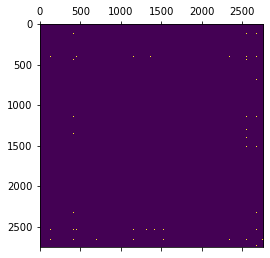

In [40]:
plt.matshow(A_feature)
print(sum(sum(A_feature)))

Properties of recipes

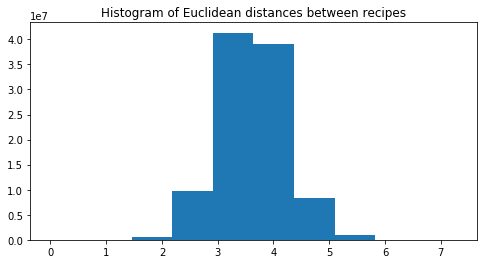

In [41]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between recipes")
plt.hist(distancerecipes.flatten());

In [157]:
threshold = mean_distance

def make_A_feature(distance, threshold, lower_threshold=0):
    A_feature = ((lower_threshold <= distance) & (distance < threshold)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

A_feature = make_A_feature(distance, threshold)